In [1]:
import importlib

In [2]:
import copy
import numpy as np
import matplotlib.colors as mplcols
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

In [3]:
import PIPPET, utils
importlib.reload(PIPPET)
importlib.reload(utils)
;

''

In [4]:
#%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

plt.style.use('default')
  
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['figure.autolayout'] = False
plt.rcParams['font.size'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
sns.set_context('paper', font_scale=0.9)

In [5]:
def merge_legends(axs):
    # Consolidated legend
    def _by_label(a):
        handles, labels = a.get_legend_handles_labels()
        return dict(zip(labels, handles))
    by_label = dict()
    for ax in axs:
        by_label.update(_by_label(ax))
    return by_label
    
def plot_phase(model, i, ax, col):
    # Phase progress
    std = 2*np.sqrt(model.V_ms[:, i])
    ax.plot(model.ts, model.mu_ms[:, i], c=col, linewidth=1.75, label='Est. phase, '+r'$\mu_t$')
    ax.fill_between(model.ts, model.mu_ms[:, i]-std, model.mu_ms[:, i]+std, alpha=0.2, facecolor=col, label='Est. var., '+r'$4\sqrt{V_t}$')
    ax.set_xlabel('Time')
    
def plot_events(model, ax, ax_temp, ax_prob=None):
    # Stimulus/Auditory events
    for i in set(model.idx_event):
        ax.axvline(model.ts[i], color='black', alpha=0.55, linestyle='--', linewidth=1, label='Auditory event')
        if ax_prob:
            ax_prob.axvline(model.ts[i], color='black', alpha=0.55, linestyle='-', linewidth=1, label='Auditory event')
    # Expected events
    for stream in model.streams:
        for e_m in stream.params.e_means:
            ax.axhline(e_m, color='grey', alpha=0.55, linestyle='--', linewidth=1, label='Event expectation')
            ax_temp.axhline(e_m, color='grey', alpha=0.55, linestyle='--', linewidth=1, label='Event expectation')

def plot_mPIPPET(model, i, wippet=False):
    cs = sns.color_palette('husl', 1+model.n_streams)

    # Create the grid
    fig = plt.figure(figsize=(8, 3))
    gs = fig.add_gridspec(1, 2,  width_ratios=(1, 4))
    ax = fig.add_subplot(gs[0, 1])
    ax_temp = fig.add_subplot(gs[0, 0], sharey=ax)

    plot_phase(model, i, ax, cs[0])
    utils.plot_template(model, ax_temp, cs[1:])
    plot_events(model, ax, ax_temp)

    ax.set_xlim([m.params.t0, m.tmax])
    
    if wippet:
        ax.set_xlim([model.params.t0, model.tmax])
        ax.set_ylim([-np.pi, np.pi])
        ax.axhline(0.0, color='blue', alpha=0.55, linestyle='--', linewidth=1)
        ax_temp.axhline(0.0, color='blue', alpha=0.55, linestyle='--', linewidth=1)
        ax.axhline(-np.pi/2, color='blue', alpha=0.55, linestyle='--', linewidth=1)
        ax.axhline(np.pi/2, color='blue', alpha=0.55, linestyle='--', linewidth=1)
        ax_temp.axhline(-np.pi/2, color='blue', alpha=0.55, linestyle='--', linewidth=1)
        ax_temp.axhline(np.pi/2, color='blue', alpha=0.55, linestyle='--', linewidth=1)
    else:
        ax.set_ylim([m.params.t0, m.tmax])

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax_temp.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax_temp.tick_params(axis='both', which='major', labelsize=8)
    
    legend = merge_legends([ax, ax_temp])
    fig.legend(legend.values(), legend.keys(), loc='upper right', #bbox_to_anchor=(0.85, 0.4),
               prop={'size':6}, ncol=2, fancybox=False, framealpha=1, edgecolor='black')
    
    plt.tight_layout()

# Tempo-picking for a metronome

In [6]:
N_PULSES = 16
e_times = np.arange(1, N_PULSES+1) * 2*np.pi
e_times[N_PULSES//2:] *= 1.1

In [7]:
taus = np.linspace(.75, 1.25, num=20)
(taus[1:]+taus[:-1])/2

array([0.76315789, 0.78947368, 0.81578947, 0.84210526, 0.86842105,
       0.89473684, 0.92105263, 0.94736842, 0.97368421, 1.        ,
       1.02631579, 1.05263158, 1.07894737, 1.10526316, 1.13157895,
       1.15789474, 1.18421053, 1.21052632, 1.23684211])

In [8]:
p_ = PIPPET.PIPPETParams()
p_.dt = 0.005
p_.overtime = 2*np.pi
p_.sigma_phi = 0.1
p_.mu_0 = 0
p_.V_0 = 0.1
p_.lambda_0 = 0.001
p_.eta_mu = 0.0
p_.eta_V = 0.0

p_.sigma_theta = 0.05
p_.tau_p = 1.0
p_.tau_p_tendency = 0.01

e_means   = np.array([0,])
e_vars    = np.array([0.025,])
e_lambdas = np.array([0.02,])
p_.add(e_times, e_means, e_vars, e_lambdas, '')

In [12]:
p_met = copy.deepcopy(p_)
p_met.tau_c_coef = 0.05 # Uncoupled
m_met = PIPPET.gcPATIPPET(p_met, taus=taus, prior=None)
m_met.run()

In [13]:
p_met_semicoupled = copy.deepcopy(p_)
p_met_semicoupled.tau_c_coef = 0.25
m_met_semicoupled = PIPPET.gcPATIPPET(p_met_semicoupled, taus=taus, prior=None)
m_met_semicoupled.run()

In [ ]:
p_met_coupled = copy.deepcopy(p_)
p_met_coupled.tau_c_coef = 1
m_met_coupled = PIPPET.gcPATIPPET(p_met_coupled, taus=taus, prior=None)
m_met_coupled.run()

In [ ]:
assert m_met.idx_event == m_met_coupled.idx_event
e_is = list(sorted(m_met.idx_event))
e_is0, e_is1 = e_is[:N_PULSES//2], e_is[N_PULSES//2:]

In [ ]:
def plot_format_dist(ax, tau_centers, tau_lines, ymax, scale=1.1):
    ax.set_yscale('linear')
    #ax.set_xscale('log')
    ax.set_ylabel(r'Probability, $p_{\tau}$')
    ax.set_xlabel(r'Tempo, $\tau$')
    ax.set_xlim([tau_centers[0], tau_centers[-1]])
    ax.vlines(tau_lines, 0, ymax*scale, ls='--', color='k', alpha=0.1)
    ax.set_xticks(tau_lines)
    ax.set_xticklabels(tau_lines)
    
def plot_mus(ax, m, cs, from_i=0, to_i=None, alpha=0.6):
    if to_i is None:
        to_i = m.ts.shape[0]
    for i, tau in enumerate(m.tau_centers):
        ax.plot(m.ts[from_i:to_i], m.mu_ms[from_i:to_i, i], c=cs[i], alpha=alpha)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(r'Phase, $\mu_t$')
    ax.set_yticks([-np.pi, 0, np.pi])
    ax.set_yticklabels([r'$-\pi$', r'$0$', r'$\pi$'])

Text(0.0, 1.0, 'Coupled')

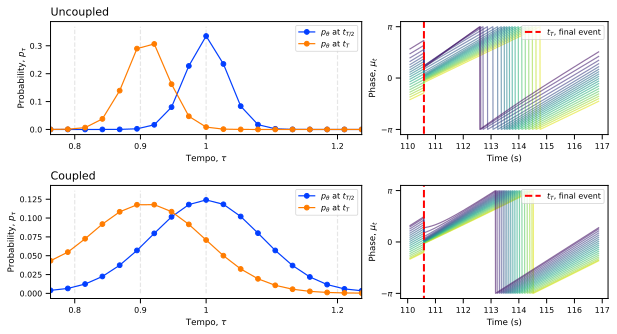

In [ ]:
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(2, 2, wspace=0.15, hspace=0.45, width_ratios=(3, 2), height_ratios=(1,1))
ax_met = fig.add_subplot(gs[0, 0])
ax_met_cont = fig.add_subplot(gs[0, 1])
ax_met_coupled = fig.add_subplot(gs[1, 0])
ax_met_coupled_cont = fig.add_subplot(gs[1, 1])

tau_centers = m_met.tau_centers
tau_lines = [.8, .9, 1, 1.2]
tau_n = len(tau_centers)

cs = sns.color_palette('bright', 2)
#cs_mus = plt.get_cmap("Greys", tau_n)
cs_mus = sns.color_palette('viridis', tau_n)[::-1]

norm = lambda ps: ps/ps.sum()
ps_met_0 = norm(m_met.p_m[e_is0[-1]])
ps_met_coupled_0 = norm(m_met_coupled.p_m[e_is0[-1]])
ps_met_1 = norm(m_met.p_m[e_is1[-1]])
ps_met_coupled_1 = norm(m_met_coupled.p_m[e_is1[-1]])
p_met_max = max(ps_met_0.max(), ps_met_1. max())
p_met_coupled_max = max(ps_met_coupled_0.max(),  ps_met_coupled_1.max())

V_met_0 = m_met.V_ms[e_is0[-1]]
V_met_coupled_0 = m_met_coupled.V_ms[e_is0[-1]]
V_met_1 = m_met.V_ms[e_is1[-1]]
V_met_coupled_1 = m_met_coupled.V_ms[e_is1[-1]]

plot_format_dist(ax_met, tau_centers, tau_lines, p_met_max)
plot_format_dist(ax_met_coupled, tau_centers, tau_lines, p_met_coupled_max)

ax_met.plot(tau_centers, ps_met_0, '-o', c=cs[0], label=r'$p_{\theta}$ at $t_{T/2}$')
ax_met.plot(tau_centers, ps_met_1, '-o', c=cs[1], label=r'$p_{\theta}$ at $t_{T}$')
#ax_met2 = ax_met.twinx()
#ax_met2.plot(tau_centers, 1/V_met_0, c=cs[1], ls='--', label=r'$V^{-1}_{\theta}$ at $t_{T/2}$')
#ax_met2.plot(tau_centers, 1/V_met_1, c=cs[1], label=r'$V^{-1}_{\theta}$ at $t_{T}$')

ax_met_coupled.plot(tau_centers, ps_met_coupled_0, '-o', c=cs[0], label=r'$p_{\theta}$ at $t_{T/2}$')
ax_met_coupled.plot(tau_centers, ps_met_coupled_1, '-o', c=cs[1], label=r'$p_{\theta}$ at $t_{T}$')
#ax_met_coupled2 = ax_met_coupled.twinx()
#ax_met_coupled2.plot(tau_centers, 1/V_met_coupled_0, c=cs[1], ls='--', label=r'$V^{-1}_{\theta}$ at $t_{T/2}$')
#ax_met_coupled2.plot(tau_centers, 1/V_met_coupled_1, c=cs[1], label=r'$V^{-1}_{\theta}$ at $t_{T}$')

ax_met.legend()
ax_met_coupled.legend()

final_t = m_met.ts[e_is[-1]]
plot_mus(ax_met_cont, m_met, cs_mus, from_i=e_is[-1]-100)
plot_mus(ax_met_coupled_cont, m_met_coupled, cs_mus, from_i=e_is[-1]-100)
ax_met_cont.axvline(final_t, -np.pi, np.pi, c='red', lw=2, ls='--', label=r'$t_{T}$, final event')
ax_met_coupled_cont.axvline(final_t, -np.pi, np.pi, c='red', lw=2, ls='--', label=r'$t_{T}$, final event')
ax_met_cont.legend(loc='upper right')
ax_met_coupled_cont.legend(loc='upper right')

#norm = mplcols.BoundaryNorm(np.arange(0,tau_n+1)-0.5, tau_n)
#sm = plt.cm.ScalarMappable(cmap=cs_mus, norm=norm)
#sm.set_array([])
#plt.colorbar(sm, ticks=np.arange(0, tau_n, 3), ax=ax_met_coupled_cont)


ax_met.set_title('Uncoupled', fontsize=11, loc='left')#, x=1.2, y=1.05)
ax_met_coupled.set_title('Coupled', fontsize=11, loc='left')#, x=1.15, y=1.05)

#fig.savefig('figures/fig_coupling.pdf', bbox_inches='tight');

In [19]:
np.zeros(3)


array([0., 0., 0.])

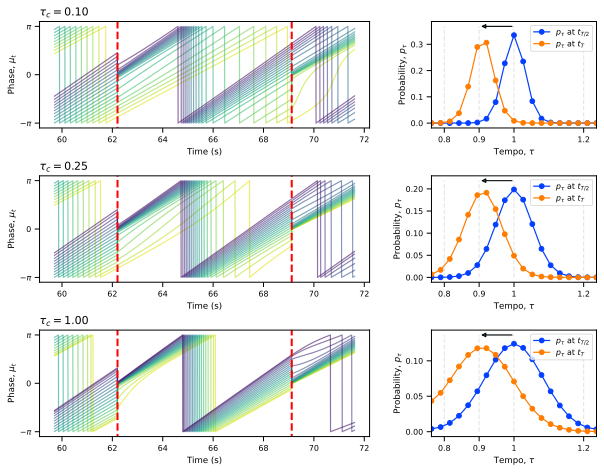

In [ ]:
fig = plt.figure(figsize=(10, 7.5))
gs = fig.add_gridspec(3, 2, wspace=0.25, hspace=0.45, width_ratios=(4, 2), height_ratios=(1,1, 1))
ax_met = fig.add_subplot(gs[0, 1])
ax_met_cont = fig.add_subplot(gs[0, 0])
ax_met_semicoupled = fig.add_subplot(gs[1, 1])
ax_met_semicoupled_cont = fig.add_subplot(gs[1, 0])
ax_met_coupled = fig.add_subplot(gs[2, 1])
ax_met_coupled_cont = fig.add_subplot(gs[2, 0])

tau_centers = m_met.tau_centers
tau_lines = [.8, .9, 1, 1.2]
tau_n = len(tau_centers)

cs = sns.color_palette('bright', 2)
#cs_mus = plt.get_cmap("Greys", tau_n)
cs_mus = sns.color_palette('viridis', tau_n)[::-1]

norm = lambda ps: ps/ps.sum()
ps_met_0 = norm(m_met.p_m[e_is0[-1]])
ps_met_semicoupled_0 = norm(m_met_semicoupled.p_m[e_is0[-1]])
ps_met_coupled_0 = norm(m_met_coupled.p_m[e_is0[-1]])
ps_met_1 = norm(m_met.p_m[e_is1[-1]])
ps_met_semicoupled_1 = norm(m_met_semicoupled.p_m[e_is1[-1]])
ps_met_coupled_1 = norm(m_met_coupled.p_m[e_is1[-1]])
p_met_max = max(ps_met_0.max(), ps_met_1. max())
p_met_semicoupled_max = max(ps_met_semicoupled_0.max(),  ps_met_semicoupled_1.max())
p_met_coupled_max = max(ps_met_coupled_0.max(),  ps_met_coupled_1.max())

V_met_0 = m_met.V_ms[e_is0[-1]]
V_met_semicoupled_0 = m_met_semicoupled.V_ms[e_is0[-1]]
V_met_coupled_0 = m_met_coupled.V_ms[e_is0[-1]]
V_met_1 = m_met.V_ms[e_is1[-1]]
V_met_semicoupled_1 = m_met_semicoupled.V_ms[e_is1[-1]]
V_met_coupled_1 = m_met_coupled.V_ms[e_is1[-1]]

plot_format_dist(ax_met, tau_centers, tau_lines, p_met_max, scale=1.1)
plot_format_dist(ax_met_semicoupled, tau_centers, tau_lines, p_met_semicoupled_max, scale=1.1)
plot_format_dist(ax_met_coupled, tau_centers, tau_lines, p_met_coupled_max, scale=1.1)

arrowprops = dict(arrowstyle="-|>", lw=1.1, ls='-')

ax_met.plot(tau_centers, ps_met_0, '-o', c=cs[0], label=r'$p_{\tau}$ at $t_{T/2}$')
ax_met.plot(tau_centers, ps_met_1, '-o', c=cs[1], label=r'$p_{\tau}$ at $t_{T}$')
ax_met.annotate("", xy=(0.9, p_met_max*1.1), xytext=(1.0, p_met_max*1.1), arrowprops=arrowprops)
#ax_met2 = ax_met.twinx()
#ax_met2.plot(tau_centers, 1/V_met_0, c=cs[1], ls='--', label=r'$V^{-1}_{\theta}$ at $t_{T/2}$')
#ax_met2.plot(tau_centers, 1/V_met_1, c=cs[1], label=r'$V^{-1}_{\theta}$ at $t_{T}$')

ax_met_semicoupled.plot(tau_centers, ps_met_semicoupled_0, '-o', c=cs[0], label=r'$p_{\tau}$ at $t_{T/2}$')
ax_met_semicoupled.plot(tau_centers, ps_met_semicoupled_1, '-o', c=cs[1], label=r'$p_{\tau}$ at $t_{T}$')
ax_met_semicoupled.annotate("", xy=(0.9, p_met_semicoupled_max*1.1), xytext=(1.0, p_met_semicoupled_max*1.1), arrowprops=arrowprops)

ax_met_coupled.plot(tau_centers, ps_met_coupled_0, '-o', c=cs[0], label=r'$p_{\tau}$ at $t_{T/2}$')
ax_met_coupled.plot(tau_centers, ps_met_coupled_1, '-o', c=cs[1], label=r'$p_{\tau}$ at $t_{T}$')
ax_met_coupled.annotate("", xy=(0.9, p_met_coupled_max*1.1), xytext=(1.0, p_met_coupled_max*1.1), arrowprops=arrowprops)
#ax_met_coupled2 = ax_met_coupled.twinx()
#ax_met_coupled2.plot(tau_centers, 1/V_met_coupled_0, c=cs[1], ls='--', label=r'$V^{-1}_{\theta}$ at $t_{T/2}$')
#ax_met_coupled2.plot(tau_centers, 1/V_met_coupled_1, c=cs[1], label=r'$V^{-1}_{\theta}$ at $t_{T}$')

ax_met.legend()
ax_met_coupled.legend()
ax_met_semicoupled.legend()

final_t = m_met.ts[e_is[-1]]
from_i = e_is1[0] - 500
to_i = e_is1[1] + 500
plot_mus(ax_met_cont, m_met, cs_mus, from_i=from_i, to_i=to_i)
plot_mus(ax_met_semicoupled_cont, m_met_semicoupled, cs_mus, from_i=from_i, to_i=to_i)
plot_mus(ax_met_coupled_cont, m_met_coupled, cs_mus, from_i=from_i, to_i=to_i)
#ax_met_cont.axvline(final_t, -np.pi, np.pi, c='red', lw=2, ls='--', label=r'$t_{T}$, final event')
#ax_met_coupled_cont.axvline(final_t, -np.pi, np.pi, c='red', lw=2, ls='--', label=r'$t_{T}$, final event')
#ax_met_cont.legend(loc='upper right')
#ax_met_coupled_cont.legend(loc='upper right')
for ax in (ax_met_cont, ax_met_semicoupled_cont, ax_met_coupled_cont):
    for i in range(0, 2):
        ax.axvline(m_met.ts[e_is1[i]], -np.pi, np.pi, c='red', lw=2, ls='--')

#norm = mplcols.BoundaryNorm(np.arange(0,tau_n+1)-0.5, tau_n)
#sm = plt.cm.ScalarMappable(cmap=cs_mus, norm=norm)
#sm.set_array([])
#plt.colorbar(sm, ticks=np.arange(0, tau_n, 3), ax=ax_met_coupled_cont)

ax_met_cont.set_title(r'$\tau_c=0.10$', fontsize=11, loc='left')#, x=1.2, y=1.05)
ax_met_semicoupled_cont.set_title(r'$\tau_c=0.25$', fontsize=11, loc='left')#, x=1.15, y=1.05)
ax_met_coupled_cont.set_title(r'$\tau_c=1.00$', fontsize=11, loc='left')#, x=1.15, y=1.05)

fig.savefig('figures/fig_coupling.pdf', bbox_inches='tight');

---

# Large, Herrera \& Velasco (2015)

https://www.frontiersin.org/articles/10.3389/fnsys.2015.00159/full

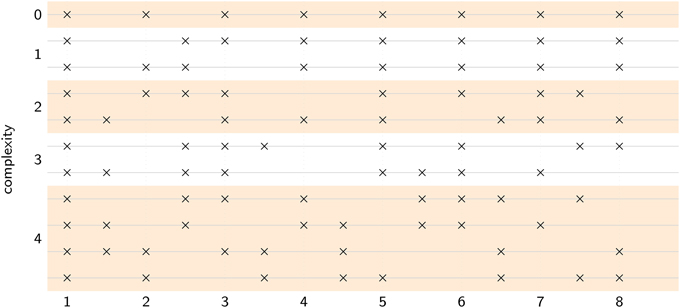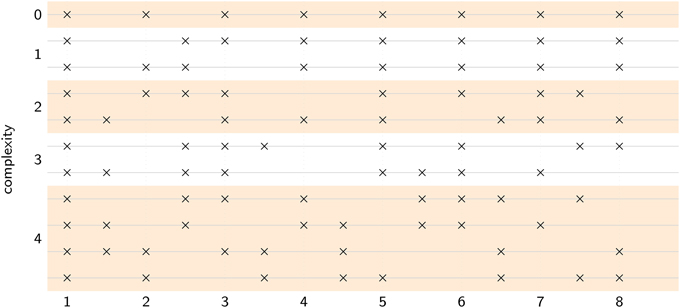

TODO:

In [15]:
temp_p = 120 #bpm
f_p = 1/(60/temp_p)
stim_p = 2
stim_scale = (stim_p/f_p)
# tau_p = 1, so scale stimulus period (2pi) accordingly
stim_scale

1.0

TODO:

In [222]:
mp_pattern = np.array([1, 1.5, 2.5, 4, 4.5, 5.5, 6, 7,])
mp_pattern_2 = np.concatenate((mp_pattern, mp_pattern+8,))
e_times_mp = (mp_pattern_2-1) * 2*np.pi * stim_scale
e_times_mp

array([ 0.        ,  3.14159265,  9.42477796, 18.84955592, 21.99114858,
       28.27433388, 31.41592654, 37.69911184, 50.26548246, 53.40707511,
       59.69026042, 69.11503838, 72.25663103, 78.53981634, 81.68140899,
       87.9645943 ])

TODO:

In [229]:
taus = np.arange(0.225, 2.55, 0.05)

Setting a prior:

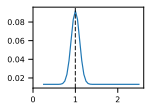

In [225]:
def gauss(x, mu, sigma, scale):
    return scale*np.exp(-(x-mu)**2/(2*sigma**2))

tau_centers = (taus[1:] + taus[:-1]) / 2
prior_gauss_tau1 = 0.1 + gauss(tau_centers, 1, .1, .6)
prior_gauss_tau1 /= prior_gauss_tau1.sum()

fig = plt.figure(figsize=(2, 1.5))
plt.plot(tau_centers, prior_gauss_tau1)
plt.axvline(1, ls='--', alpha=0.8, c='k')
plt.xlim([0, None])
plt.show()

In [226]:
# 4.2
p_gfnn = PIPPET.PIPPETParams()
p_gfnn.dt = 0.005
p_gfnn.overtime = np.pi/10.
p_gfnn.sigma_phi = 0.1
p_gfnn.mu_0 = 0
p_gfnn.V_0 = 0.1
p_gfnn.lambda_0 = 0.001
p_gfnn.eta_mu = 0.0
p_gfnn.eta_V = 0.0
#
p_gfnn.sigma_theta = 0.05
p_gfnn.tau_p = 1.0
p_gfnn.tau_p_tendency = 0.025
p_gfnn.tau_c_coef = 1
#
p_mp = copy.deepcopy(p_gfnn)
e_means   = np.array([0, np.pi])
e_vars    = np.array([0.5, 0.5])
e_lambdas = np.array([0.05, 0.05])
p_mp.add(e_times_mp, e_means, e_vars, e_lambdas, '')
m_mp = PIPPET.gradWIPPET(p_mp, taus=taus, prior=prior_gauss_tau1)
m_mp.run()

Text(0.5, 0, 'Theta, $\\theta$')

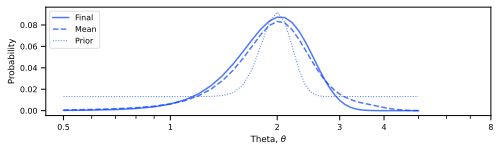

In [227]:
m = m_mp

temps = [.5, 1, 2, 3, 4, 8,]
cs = sns.color_palette('bright', 2)

ps_final = m.p_m[-1]
ps_final /= ps_final.sum()
ps_mean = np.mean(m.p_m, axis=0)
ps_mean /= ps_mean.sum()

fig, ax1 = plt.subplots(figsize=(8, 2))
ax1.plot(m.tau_centers*stim_p, ps_final, c=cs[0], lw=1.5, alpha=.7, label='Final')
ax1.plot(m.tau_centers*stim_p, ps_mean, c=cs[0], lw=1.5, ls='--', alpha=.7, label='Mean')
ax1.plot(m.tau_centers*stim_p, prior_gauss_tau1, c=cs[0], lw=1, ls=':', alpha=.7, label='Prior')
#ax1.vlines(temps, 0, 1, ls='--', color='k', alpha=0.1)
ax1.set_yscale('linear')
ax1.set_xscale('log')
#ax1.set_ylim([-0.01, 1])
ax1.set_xticks(temps)
ax1.set_xticklabels(temps)
ax1.set_ylabel('Probability')
#ax1.yaxis.label.set_color(cs[0])
ax1.tick_params(axis='y')#, colors=cs[0])
ax1.legend(loc='upper left')

# ax2 = ax1.twinx()
# ax2.plot(m.tau_centers*stim_p, 1/m.V_ms[-1], c=cs[1], alpha=.7, ls='--')
# ax2.set_yscale('linear')
# ax2.set_ylabel('|y|')
# ax2.yaxis.label.set_color(cs[1])
# ax2.tick_params(axis='y', colors=cs[1])

ax1.set_xlabel(r'Theta, $\theta$')

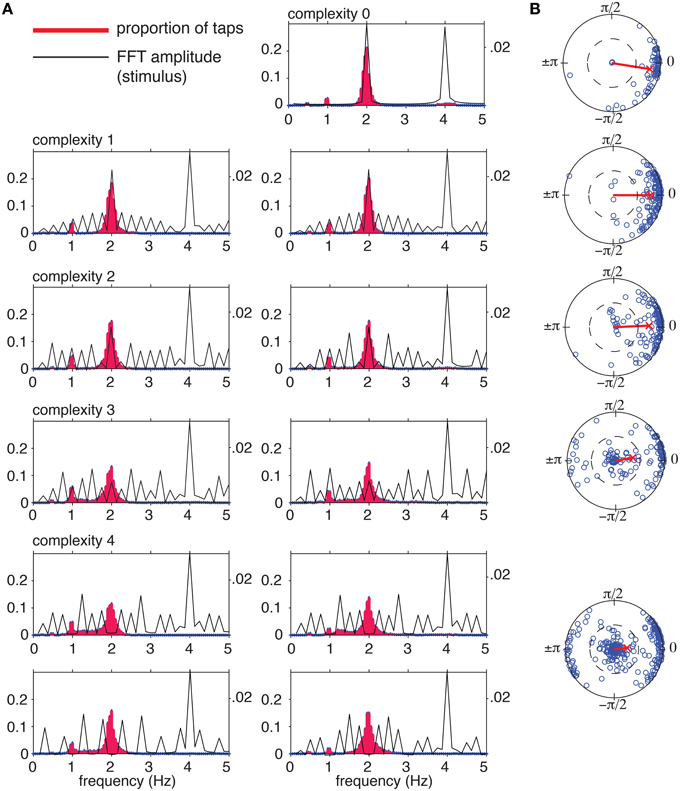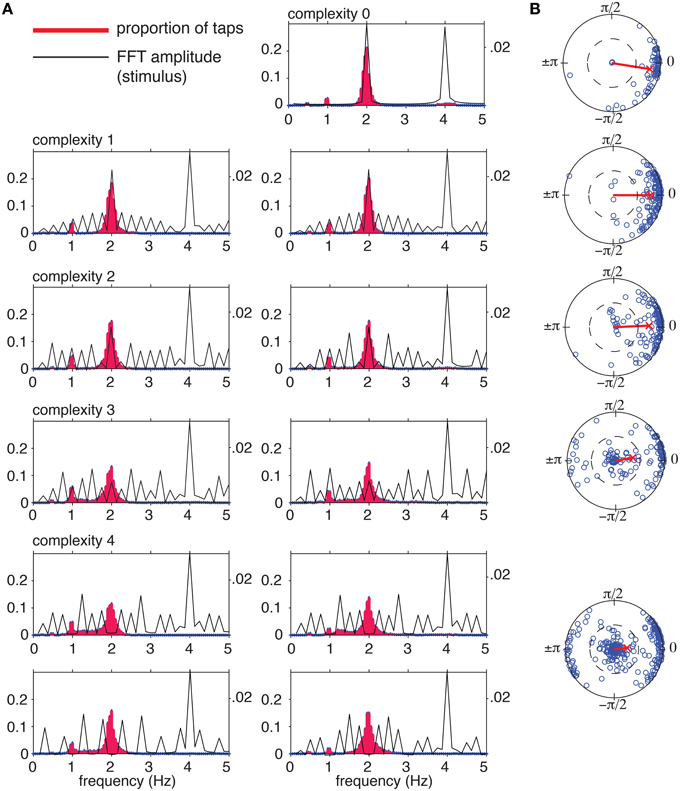